# Statistical Arbitrage
- Trading Strategy โดยใช้กลยุทธ์ในการหาคู่ของสินทรัพย์ที่มีแนวโน้มปรับตัวในทิศทางเดียวกัน และเมื่อเกิดความผิดปกติขึ้นเราจะคาดหวังว่าจะให้ราคาสินทรัพย์กลับเข้าสู่ค่าเฉลี่ย

In [5]:
import sys
import os
from IPython.display import display, HTML 
%config InlineBackend.figure_format='retina'

# กำหนด path ไปยังโฟลเดอร์ 'libs' ที่อยู่ข้างนอกของ 'subfolder'
# ใช้ os.path.abspath สำหรับการรับ absolute path
libs_path = os.path.abspath(os.path.join(os.getcwd(), '../..', ''))

# ใส่ path นี้ไปที่ตำแหน่งแรกใน sys.path เพื่อให้ Python ค้นหาที่นี่ก่อน
if libs_path not in sys.path:
    sys.path.insert(0, libs_path)

import starfishXapi as sx
from starfishXapi.set_api import fnType
sx.enable_autoreload()
print(sx.__version__)

Autoreload enabled.
0.00104


In [8]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=b64ec2febe5783581278d452fa5a7beb1ef76ecfdce0b3766410929d83775503
  Stored in directory: /Users/nattapatattiratanasunthron/Library/Caches/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta  # ไลบรารีสำหรับการคำนวณ technical indicators เช่น RSI

## Quantitative Strategies : Pair Trading
<b>concept</b><br> 
1️⃣.หาสินทรัพย์สองตัวที่ราคามีการเคลื่อนไหวสัมพันธ์กัน<br> 
2️⃣.ค่าความแตกต่าง spread ราคาระหว่างสินทรัพย์ทั้งสอง โดยตั้งสมมติฐานว่า spead จะคงที่ไม่เปลี่ยนแปลงมากนัก <br>
3️⃣.เมื่อเกิดความคลาดเคลื่อนที่มากเกินไป และคาดว่าราคาจะกลับมาสู่ค่าเฉลี่ยในภายหลัง<br> 
4️⃣.หาความผิดปกติด้วย z-score และวางกลยุทธ์ตามระดับของ z-score  ที่กำหนด

In [48]:
# สร้างข้อมูลจำลองราคา

In [462]:
# ตัวอย่างการจำลอง ข้อมูล
S0 = 50  # ราคาหุ้นเริ่มต้น
mu = 0.02 # ค่า drift (0% ต่อปี)
sigma = 0.04  # ความผันผวน (4% ต่อปี)
T = 3 # จำลอง 3 ปี (252 วันทำการ)
dt = 1/252  # เวลาย่อย 1 วัน
N = int(T / dt)  # จำนวนก้าว

while(1):
    # เรียกใช้ฟังก์ชัน
    stock_prices1, time_steps = sx.generate_gbm_price(S0+30, mu+0.02, sigma, T, dt, N)
    stock_prices2, time_steps = sx.generate_gbm_price(S0*.1, mu, sigma, T, dt, N)
    
    basket = ['asset1','asset2']
    
    dates = pd.date_range(start="2020-01-01", periods=N)
    # สร้าง DataFrame เพื่อแสดงข้อมูล
    df1 = pd.DataFrame({'Date': dates,'close': stock_prices1})
    df2 = pd.DataFrame({'Date': dates,'close': stock_prices2})
    
    df = pd.concat([df1['close'],df2['close']],axis=1)
    df.columns = basket
    df['Date'] = dates
    df = df.set_index('Date')

    if(df.corr()['asset1']['asset2']>0.9):
      break  

df.tail(5)

asset1    asset2
Date                           
2022-01-21  93.807534  5.639049
2022-01-22  93.727320  5.629102
2022-01-23  94.350115  5.644619
2022-01-24  93.892711  5.628383
2022-01-25  94.329190  5.615056

In [464]:
df.corr()

asset1    asset2
asset1  1.000000  0.942249
asset2  0.942249  1.000000

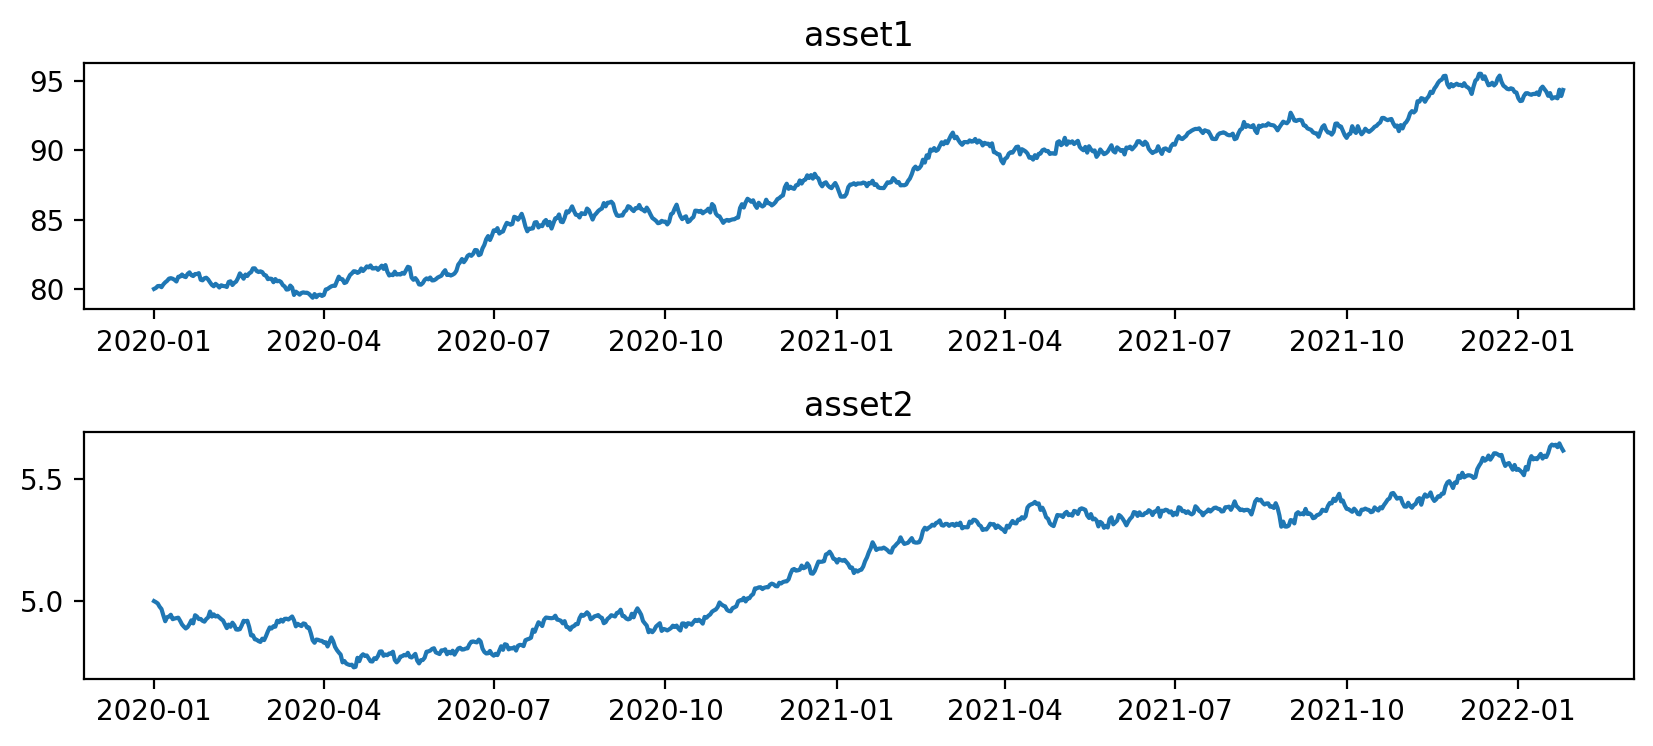

In [466]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
ax1.plot(df.index,df['asset1'])
ax1.set_title('asset1')

plt.subplots_adjust(hspace=0.5) 

ax2.plot(df.index,df['asset2'])
ax2.set_title('asset2')
#plt.xticks(rotation=45)
plt.show()

In [468]:
#df['spread'] = df['asset1'].pct_change() - df['asset2'].pct_change()
df['spread'] = df['asset1'] - df['asset2'] 

test = 'rolling' 

if(test=='rolling'):
    window_size = 30  # Use a 30-day window
    df['rollingMean'] = df['spread'].rolling(window=window_size).mean()
    df['rollingStd'] = df['spread'].rolling(window=window_size).std()
    
    # Calculate Z-score
    df['z-score'] = (df['spread'] - df['rollingMean']) / df['rollingStd']
else:
    mean = df['spread'].mean()
    std = df['spread'].std()
    df['z-score'] = (df['spread'] - mean) / std
    
df

asset1    asset2     spread  rollingMean  rollingStd   z-score
Date                                                                         
2020-01-01  80.029942  5.000180  75.029761          NaN         NaN       NaN
2020-01-02  80.100484  4.995871  75.104613          NaN         NaN       NaN
2020-01-03  80.233640  4.990506  75.243134          NaN         NaN       NaN
2020-01-04  80.245677  4.977247  75.268430          NaN         NaN       NaN
2020-01-05  80.156451  4.967779  75.188672          NaN         NaN       NaN
...               ...       ...        ...          ...         ...       ...
2022-01-21  93.807534  5.639049  88.168485    88.561787    0.330582 -1.189726
2022-01-22  93.727320  5.629102  88.098218    88.521178    0.308784 -1.369759
2022-01-23  94.350115  5.644619  88.705497    88.509081    0.293329  0.669611
2022-01-24  93.892711  5.628383  88.264328    88.484980    0.282167 -0.781989
2022-01-25  94.329190  5.615056  88.714134    88.480438    0.277134  0.843258

[756 rows x 6 columns]

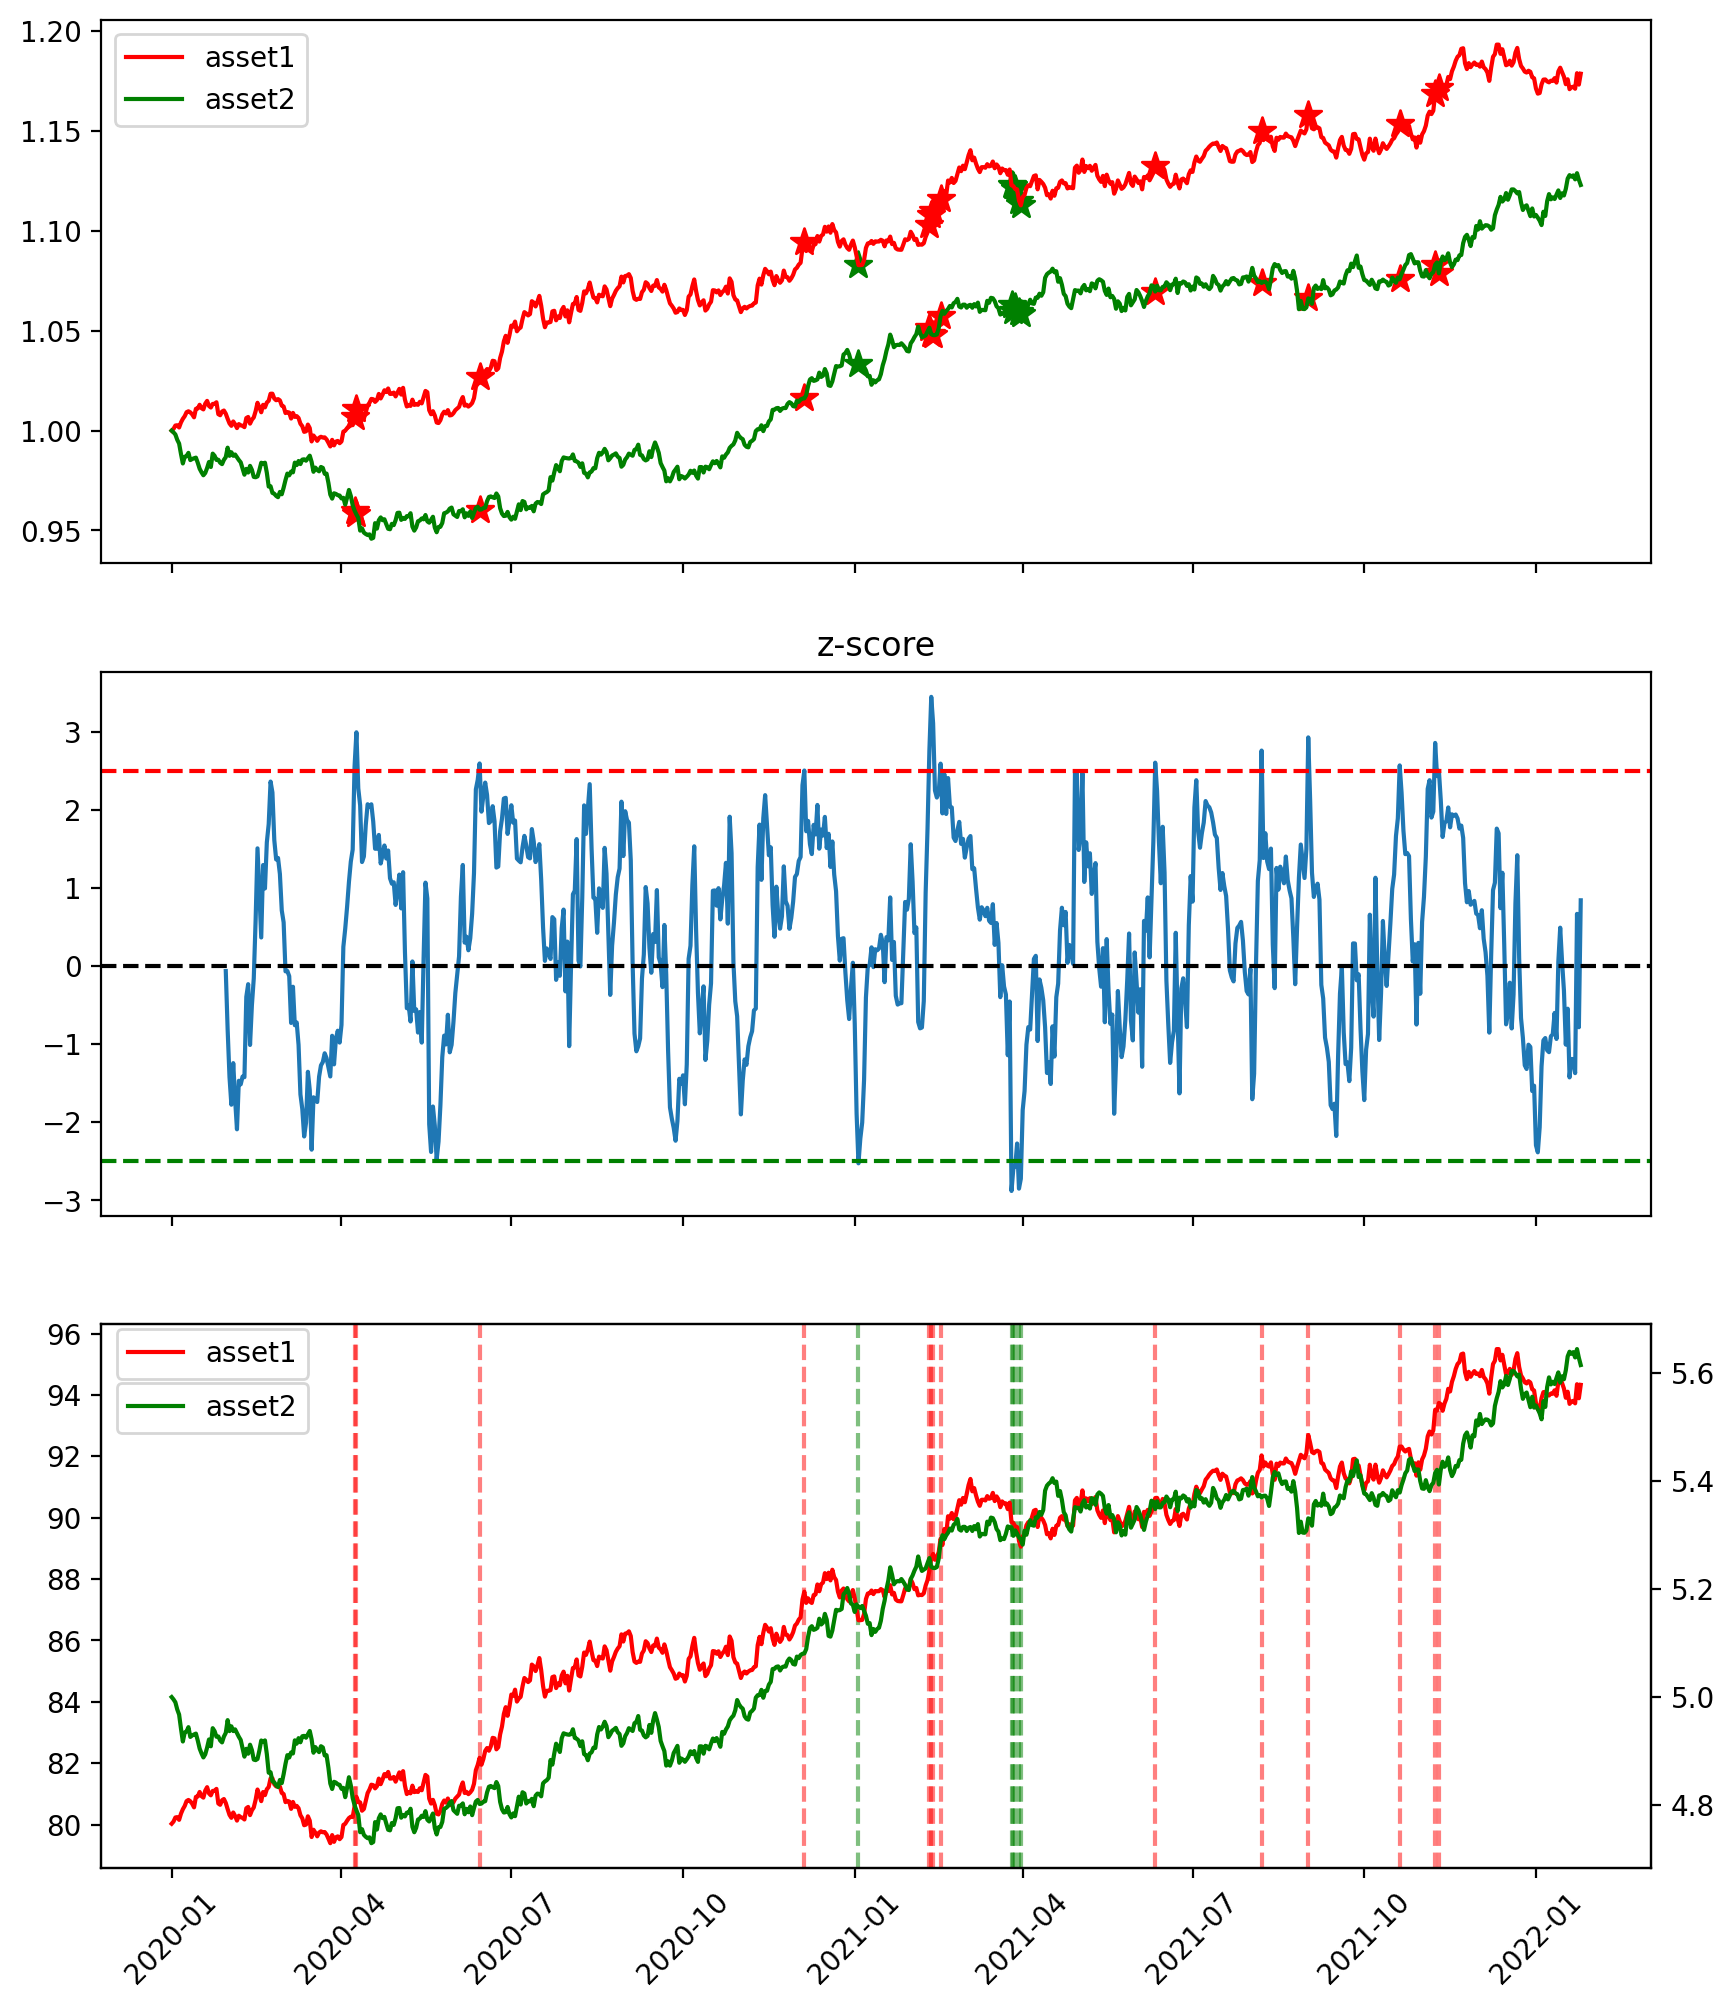

In [470]:
df['asset1_norm'] = df['asset1']/df['asset1'].iloc[0]
df['asset2_norm'] = df['asset2']/df['asset2'].iloc[0]
 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
if(test == 'rolling'):
    k1 = df[df['z-score']>2.5]
    k2 = df[df['z-score']<-2.5]
else:
    k1 = df[df['z-score']>df['z-score'].max()*0.9]
    k2 = df[df['z-score']<df['z-score'].min()*0.9]


########

ax1.plot(df.index,df['asset1_norm'],color='r',label='asset1')
ax1.plot(df.index,df['asset2_norm'],color='g',label='asset2')

ax1.scatter(k1.index,k1['asset1_norm'],color='r',marker='*',s=100)
ax1.scatter(k1.index,k1['asset2_norm'],color='r',marker='*',s=100)
ax1.scatter(k2.index,k2['asset1_norm'],color='g',marker='*',s=100)
ax1.scatter(k2.index,k2['asset2_norm'],color='g',marker='*',s=100)
ax1.legend()
########

########
ax2.plot(df.index,df['z-score'])
ax2.axhline(y=2.5, color='r', linestyle='--', label='Z-score = 2')
ax2.axhline(y=-2.5, color='g', linestyle='--', label='Z-score = -2')
ax2.axhline(y=0, color='black', linestyle='--', label='Z-score = 0')
ax2.set_title('z-score')

########


########
positions = [1, 2, 3]  # ตำแหน่งของเส้นแนวตั้ง
for pos in k1.index:
   ax3.axvline(x=pos, color='red', linestyle='--',alpha=0.5)
for pos in k2.index:
   ax3.axvline(x=pos, color='green', linestyle='--',alpha=0.5)
    
ax3.plot(df.index,df['asset1'],color='red',label='asset1')
ax4 = ax3.twinx()
ax4.plot(df.index,df['asset2'],color='green',label='asset2')
#ax3.fill_between(x, y1, y2, color='gray', alpha=0.3, label='Area between')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(loc=(0.01, 0.9))
ax4.legend(loc=(0.01, 0.8))
########


plt.xticks(rotation=45)
plt.show()

In [472]:
# Import the necessary libraries for ADF test
import statsmodels.tsa.stattools as ts

adf_result = ts.adfuller(df['spread'].dropna())

# Display the results of the ADF test
adf_result_summary = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Number of Lags Used': adf_result[2],
    'Number of Observations Used': adf_result[3],
    'Critical Values': adf_result[4],
    'Maximized Information Criterion (AIC)': adf_result[5]
}

adf_result_summary

{'ADF Statistic': -0.916325011815901,
 'p-value': 0.7825488297919139,
 'Number of Lags Used': 0,
 'Number of Observations Used': 755,
 'Critical Values': {'1%': -3.4390409569041207,
  '5%': -2.865375732701395,
  '10%': -2.568812543748081},
 'Maximized Information Criterion (AIC)': -62.80354054693635}

## ทดสอบ Corr หุ้น
- advanc VS intuch

In [7]:
dataReader = sx.HistStockPrice()

*you are using nologin method, data you access may be limited


In [606]:
import pandas as pd
basket = ['JMART','SGC']
asset1 = basket[0]
asset2 = basket[1]

df1 = dataReader.getPrice(symbol=asset1,start='2023-01-01',stop='2024-09-18') 
df2 = dataReader.getPrice(symbol=asset2,start='2023-01-01',stop='2024-09-18') 

df = pd.concat([df1['close'],df2['close']],axis=1)
df.columns = [asset1,asset2]
#df = df.drop()
df = df.dropna()
df.tail(5)

JMART   SGC
Date                   
2024-09-12   17.0  1.60
2024-09-13   16.8  1.68
2024-09-16   16.8  1.77
2024-09-17   16.8  1.69
2024-09-18   16.3  1.66

In [608]:
df.head(5)

JMART   SGC
Date                   
2023-01-03  41.00  4.72
2023-01-04  40.75  4.76
2023-01-05  40.00  4.48
2023-01-06  40.25  4.46
2023-01-09  41.50  4.78

In [610]:
df.corr()

JMART       SGC
JMART  1.000000  0.924692
SGC    0.924692  1.000000

In [612]:
#df['spread'] = df['asset1'].pct_change() - df['asset2'].pct_change()
df['spread'] = df[asset1] - df[asset2] 

test = 'rolling' 
if(test=='rolling'):
    window_size = 30  # Use a 30-day window
    df['rollingMean'] = df['spread'].rolling(window=window_size).mean()
    df['rollingStd'] = df['spread'].rolling(window=window_size).std()
    
    # Calculate Z-score
    df['z-score'] = (df['spread'] - df['rollingMean']) / df['rollingStd']
else:
    mean = df['spread'].mean()
    std = df['spread'].std()
    df['z-score'] = (df['spread'] - mean) / std
    
df.tail(5)

JMART   SGC  spread  rollingMean  rollingStd   z-score
Date                                                              
2024-09-12   17.0  1.60   15.40    12.392333    2.318535  1.297227
2024-09-13   16.8  1.68   15.12    12.523667    2.358736  1.100731
2024-09-16   16.8  1.77   15.03    12.669333    2.374559  0.994149
2024-09-17   16.8  1.69   15.11    12.858667    2.333456  0.964806
2024-09-18   16.3  1.66   14.64    13.054000    2.222910  0.713479

In [632]:
report = df.tail(60) #zoom report

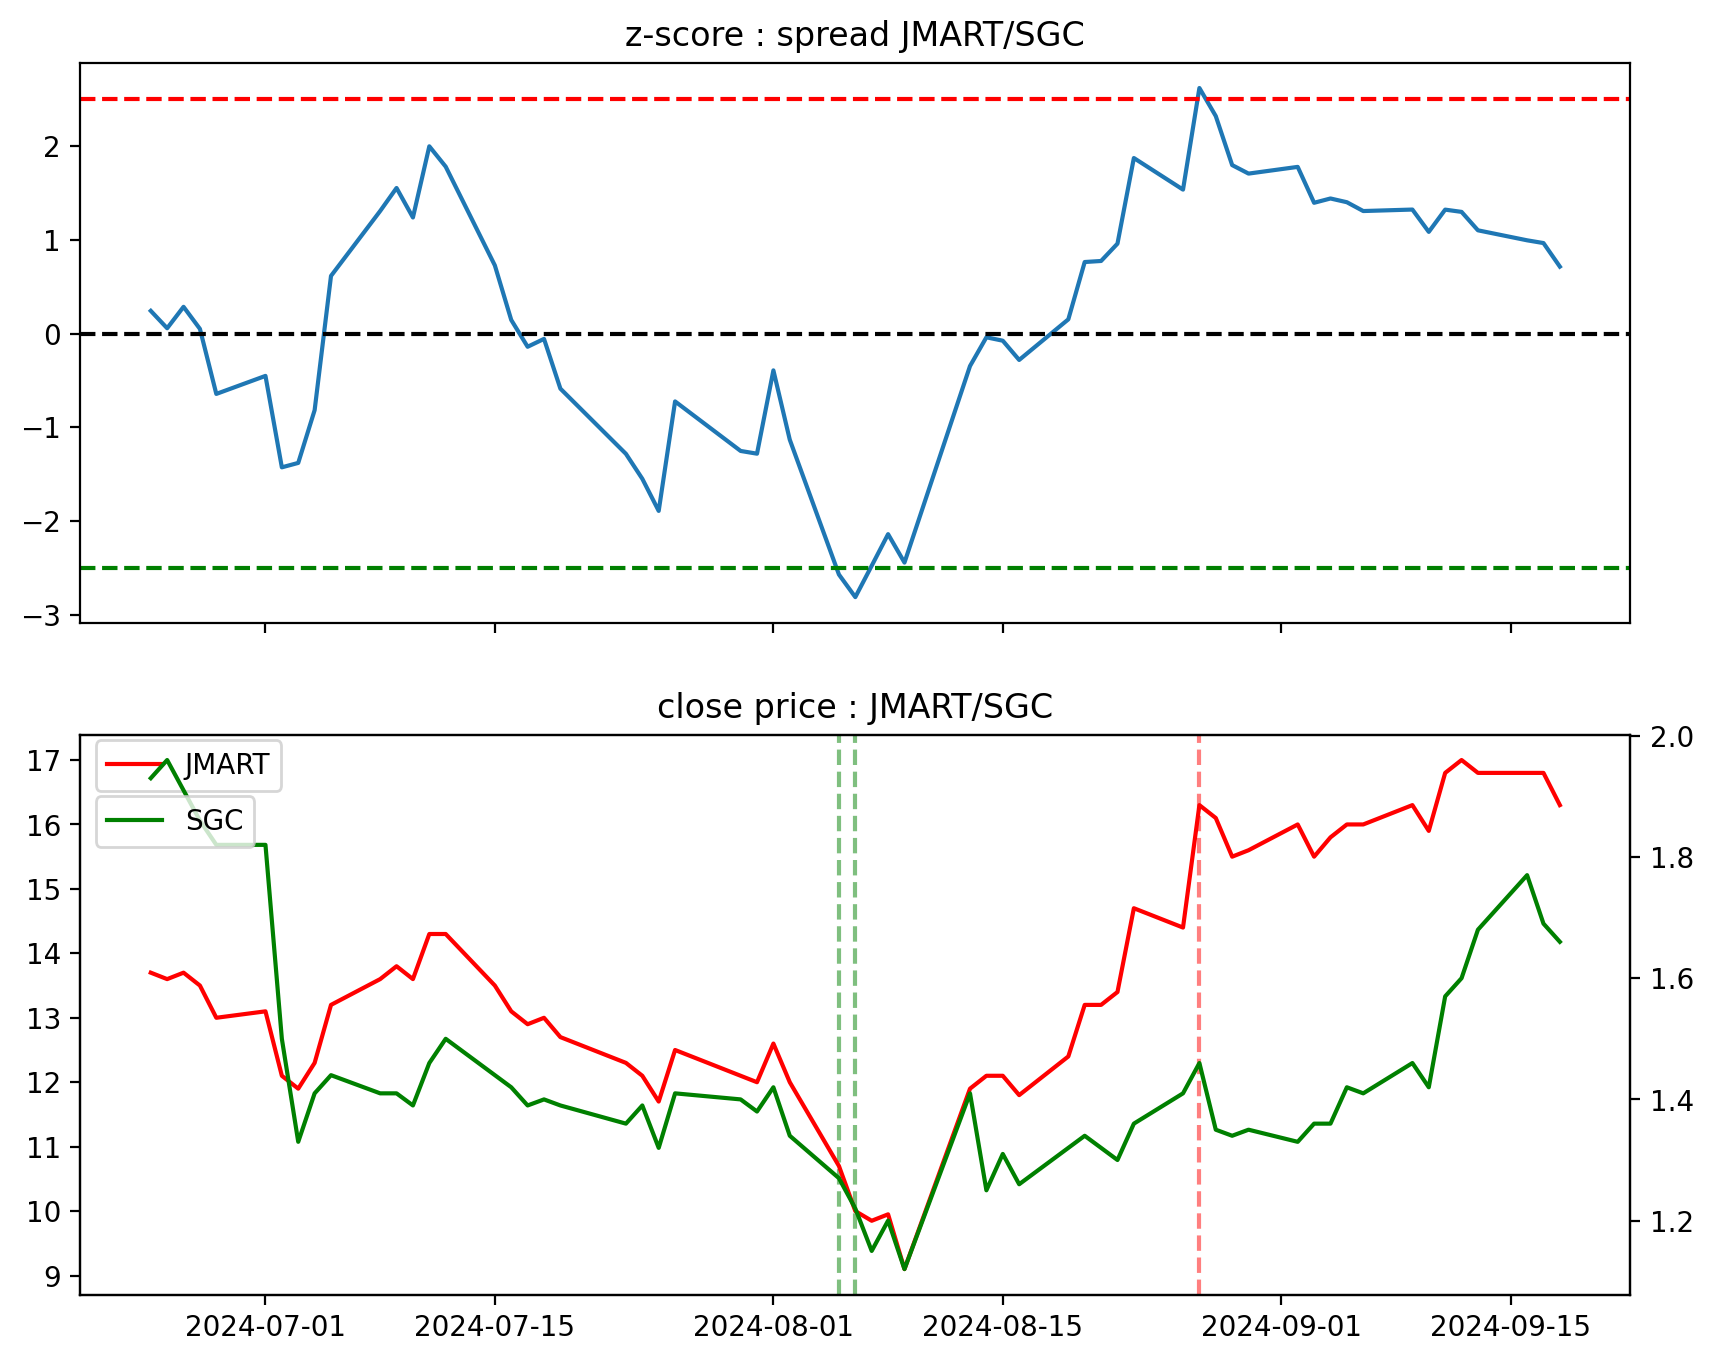

In [634]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

if(test == 'rolling'):
    k1 = report[report['z-score']>2.5]
    k2 = report[report['z-score']<-2.5]
else:
    k1 = dreportf[report['z-score']>report['z-score'].max()*0.9]
    k2 = report[report['z-score']<report['z-score'].min()*0.9]
    
########
ax1.plot(report.index,report['z-score'])
ax1.axhline(y=2.5, color='r', linestyle='--', label='Z-score = 2')
ax1.axhline(y=-2.5, color='g', linestyle='--', label='Z-score = -2')
ax1.axhline(y=0, color='black', linestyle='--', label='Z-score = 0')
ax1.set_title(f'z-score : spread {asset1}/{asset2}')
########



########
positions = [1, 2, 3]  # ตำแหน่งของเส้นแนวตั้ง
for pos in k1.index:
   ax2.axvline(x=pos, color='red', linestyle='--',alpha=0.5)
for pos in k2.index:
   ax2.axvline(x=pos, color='green', linestyle='--',alpha=0.5)
    
ax2.plot(report.index,report[asset1],color='red',label=asset1)


ax3 = ax2.twinx()
ax3.plot(report.index,report[asset2],color='green',label=asset2)
#ax3.fill_between(x, y1, y2, color='gray', alpha=0.3, label='Area between')
ax3.tick_params(axis='x', rotation=45)
ax2.legend(loc=(0.01, 0.9))
ax3.legend(loc=(0.01, 0.8))
plt.title(f'close price : {asset1}/{asset2}')
########


plt.xticks(rotation=45)
plt.show()

In [618]:
df[[asset1,asset2]].corr()

JMART       SGC
JMART  1.000000  0.924692
SGC    0.924692  1.000000

## Cointegration 
- Correlation: สมมติว่าคุณกำลังดูการเคลื่อนไหวของหุ้นสองตัวในระยะสั้น (เช่น การเทรดรายวันหรือรายสัปดาห์) คุณอาจใช้ Correlation ในการวิเคราะห์ว่า หุ้นทั้งสองเคลื่อนไหวในทิศทางเดียวกันหรือไม่ หากทั้งสองมี Correlation สูง คุณอาจพิจารณาว่าทั้งสองหุ้นมีแนวโน้มที่จะเคลื่อนไหวในทิศทางเดียวกันในระยะสั้น

- Cointegration: สมมติว่าคุณกำลังใช้กลยุทธ์ Pair Trading คุณต้องการหาหุ้นสองตัวที่มีแนวโน้มจะกลับเข้าสู่ความสัมพันธ์เดิม (Mean-Reversion) ในระยะยาว คุณจะเลือกใช้ Cointegration เพื่อวิเคราะห์ว่าหุ้นสองตัวนี้มีแนวโน้มจะเคลื่อนไหวร่วมกันในระยะยาวหรือไม่ แม้ว่าจะมีการเบี่ยงเบนกันในระยะสั้น

การตีความ <br>
✅ ผลลัพธ์จะคืนค่า p-value ถ้า p-value ต่ำกว่า 0.05 แสดงว่ามี Cointegration อย่างมีนัยสำคัญทางสถิติ (เช่น 95%) <br>
❎ ถ้า p-value ≥ 0.05 แสดงว่าไม่มี Cointegration

มี Cointegration ระหว่างหุ้น ADVANC และ INTUCH , p_value = 0.0011480855391042032


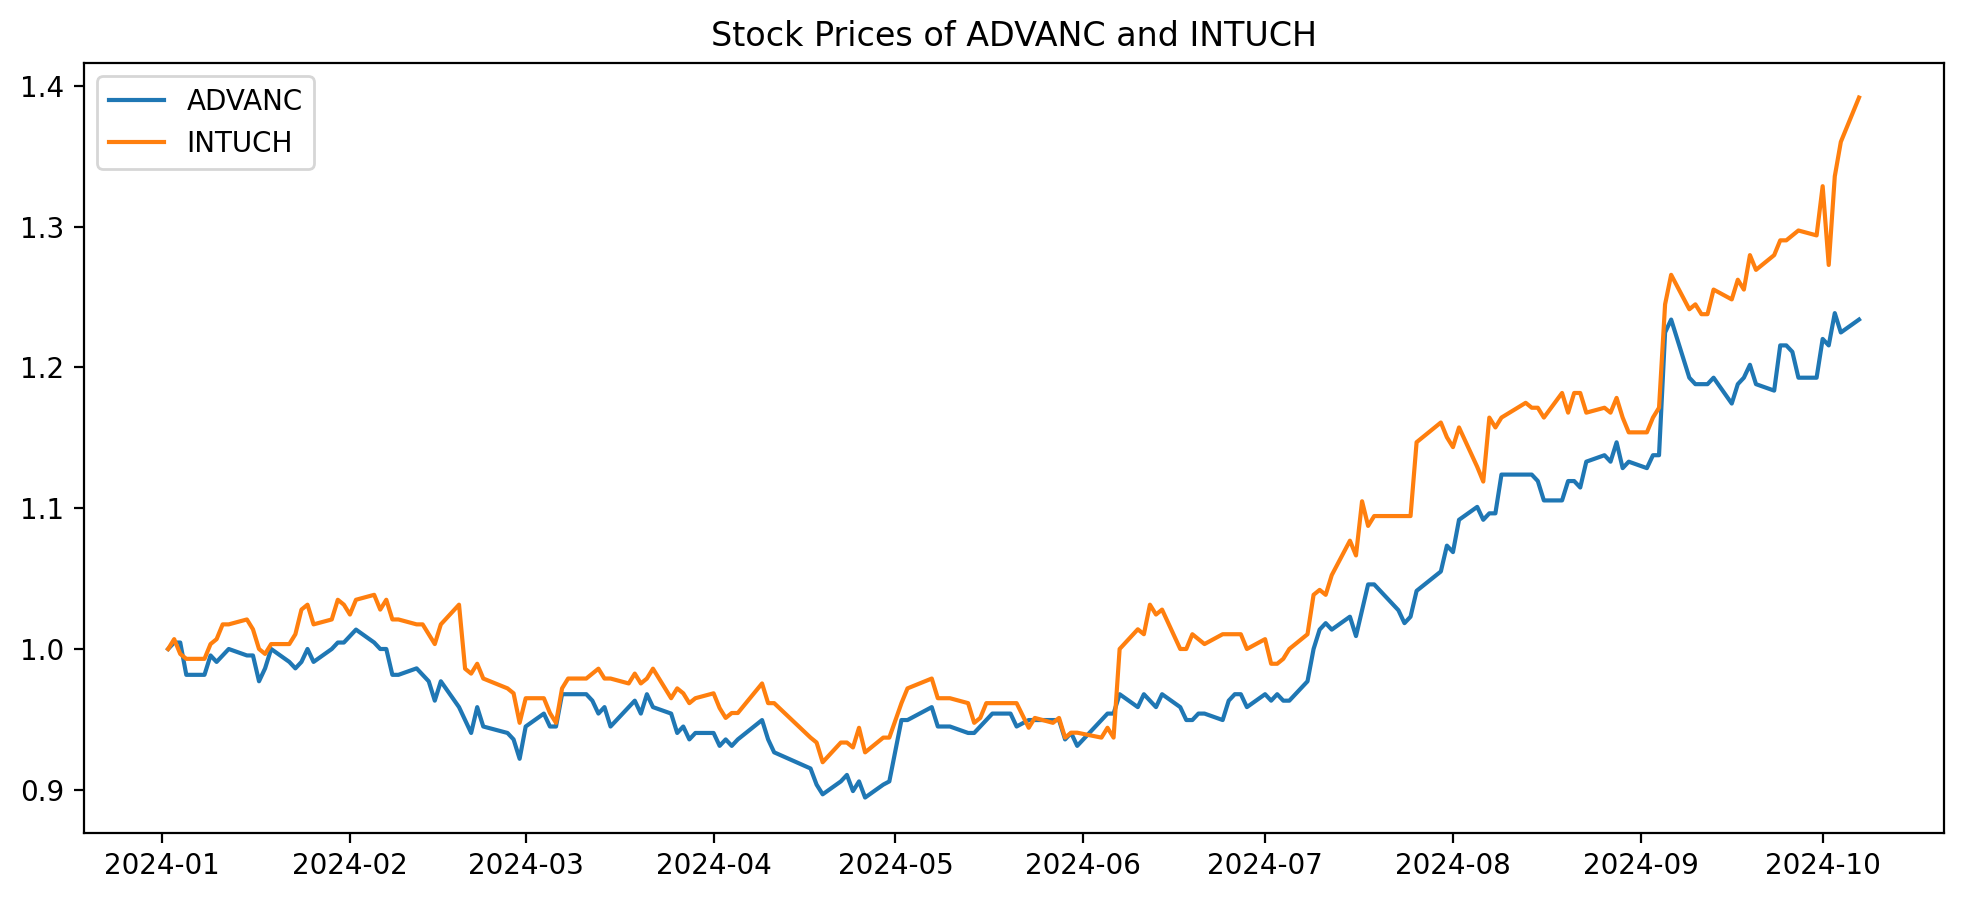

In [13]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# ดึงข้อมูลราคาหุ้น 2 ตัว
symbol1 = 'ADVANC'
symbol2 = 'INTUCH'
df_symbol1 = dataReader.getPrice(symbol=symbol1,start='2024-01-01',stop='2024-10-07')
df_symbol2 = dataReader.getPrice(symbol=symbol2,start='2024-01-01',stop='2024-10-07')

df_symbol1['close_norm'] = df_symbol1['close']/df_symbol1['close'].iloc[0]
df_symbol2['close_norm'] = df_symbol2['close']/df_symbol2['close'].iloc[0]
# ทดสอบ Cointegration  
p1 = df_symbol1['close'] 
p2 = df_symbol2['close'] 

score, p_value, _ = coint(p1 ,p2)

if p_value < 0.05:
    print(f"มี Cointegration ระหว่างหุ้น {symbol1} และ {symbol2} , p_value = {p_value}")
else:
    print(f"ไม่มี Cointegration ระหว่างหุ้น {symbol1} และ {symbol2} , p_value = {p_value}")

# แสดงกราฟราคาหุ้น
plt.subplots(figsize=(12,5))
plt.plot(df_symbol1['close_norm'], label=symbol1)
plt.plot(df_symbol2['close_norm'], label=symbol2)
plt.title(f'Stock Prices of {symbol1} and {symbol2}')
plt.legend()
plt.show()

In [14]:
pd.concat([df_symbol1['close'],df_symbol2['close']],axis=1).corr()

close    close
close  1.00000  0.98094
close  0.98094  1.00000

มี Cointegration ระหว่างหุ้น JMART และ JMT , p_value = 0.0006188141838225185


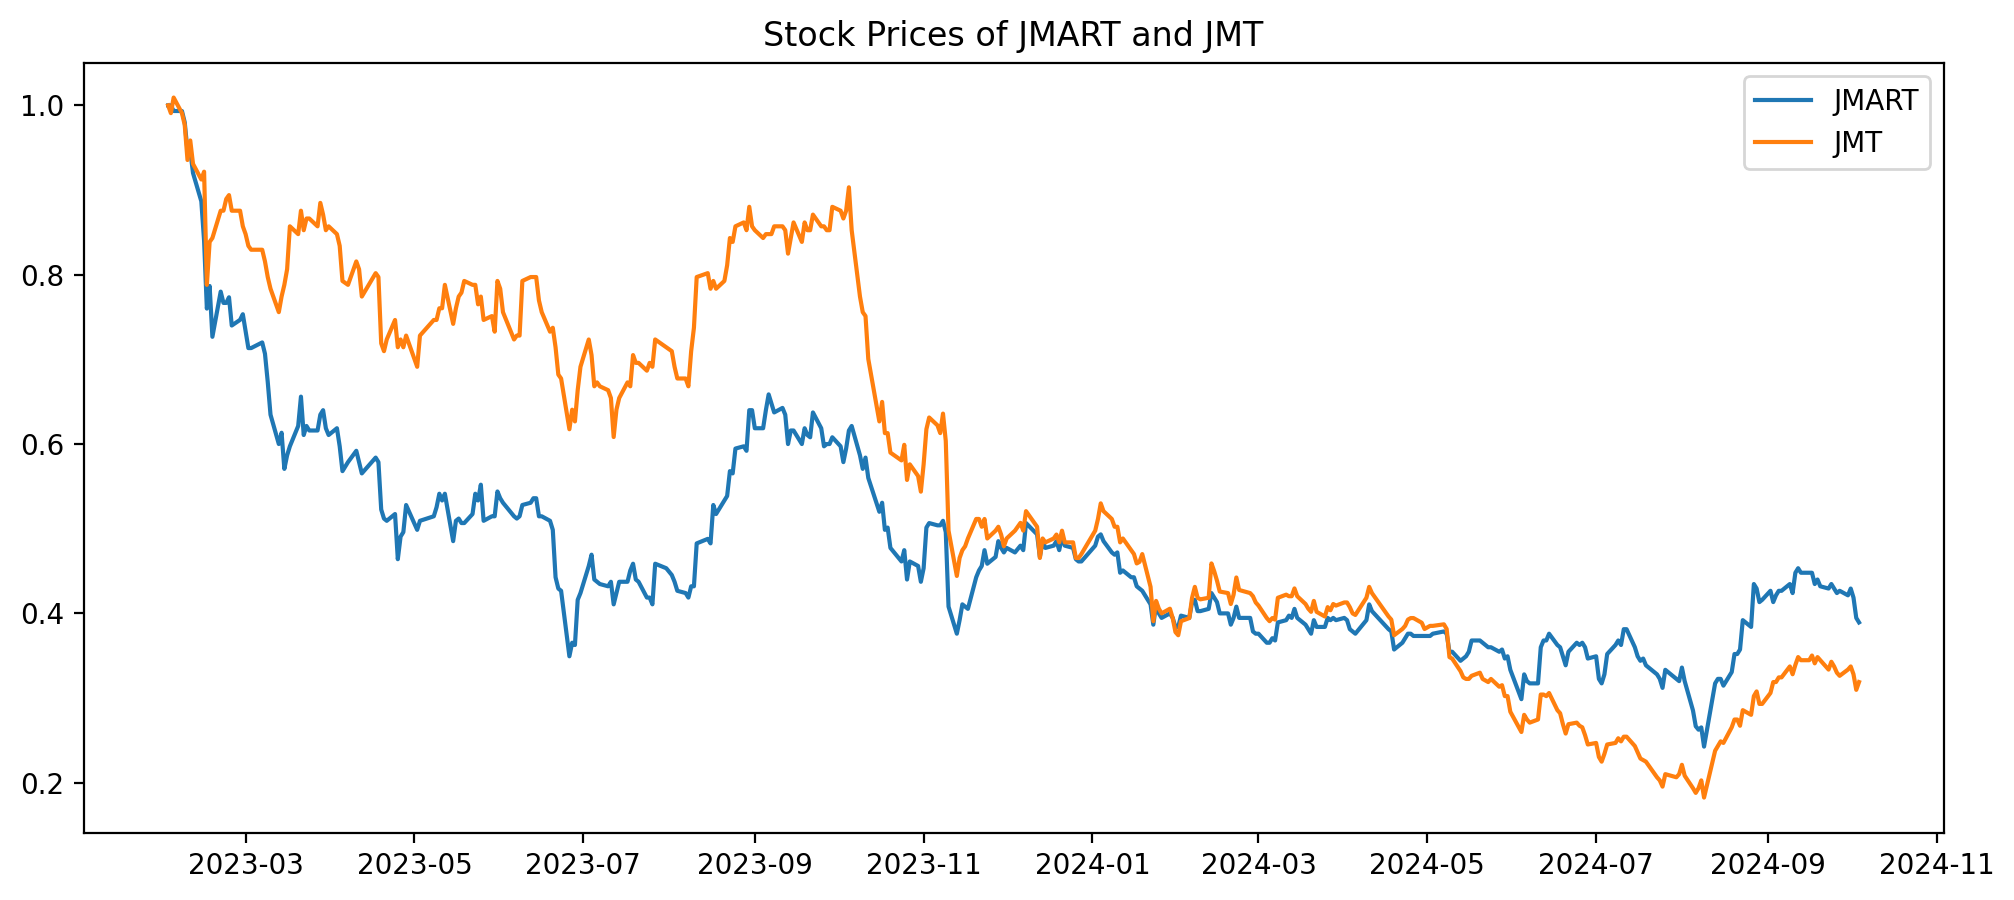

In [17]:
# ดึงข้อมูลราคาหุ้น 2 ตัว
symbol1 = 'JMART'
symbol2 = 'JMT'
df_symbol1 = dataReader.getPrice(symbol=symbol1,start='2023-02-01',stop='2024-10-04') # แอบปรับช่วงเวลา
df_symbol2 = dataReader.getPrice(symbol=symbol2,start='2023-02-01',stop='2024-10-04')

df_symbol1['close_norm'] = df_symbol1['close']/df_symbol1['close'].iloc[0]
df_symbol2['close_norm'] = df_symbol2['close']/df_symbol2['close'].iloc[0]
# ทดสอบ Cointegration  
p1 = df_symbol1['close'] 
p2 = df_symbol2['close'] 

score, p_value, _ = coint(p1 ,p2)

if p_value < 0.05:
    print(f"มี Cointegration ระหว่างหุ้น {symbol1} และ {symbol2} , p_value = {p_value}")
else:
    print(f"ไม่มี Cointegration ระหว่างหุ้น {symbol1} และ {symbol2} , p_value = {p_value}")

# แสดงกราฟราคาหุ้น
plt.subplots(figsize=(12,5))
plt.plot(df_symbol1['close_norm'], label=symbol1)
plt.plot(df_symbol2['close_norm'], label=symbol2)
plt.title(f'Stock Prices of {symbol1} and {symbol2}')
plt.legend()
plt.show()

In [19]:
pd.concat([df_symbol1['close'],df_symbol2['close']],axis=1).corr()

close     close
close  1.000000  0.849858
close  0.849858  1.000000

มี Cointegration ระหว่างหุ้น SET50 และ SET , p_value = 0.0015756413796684738


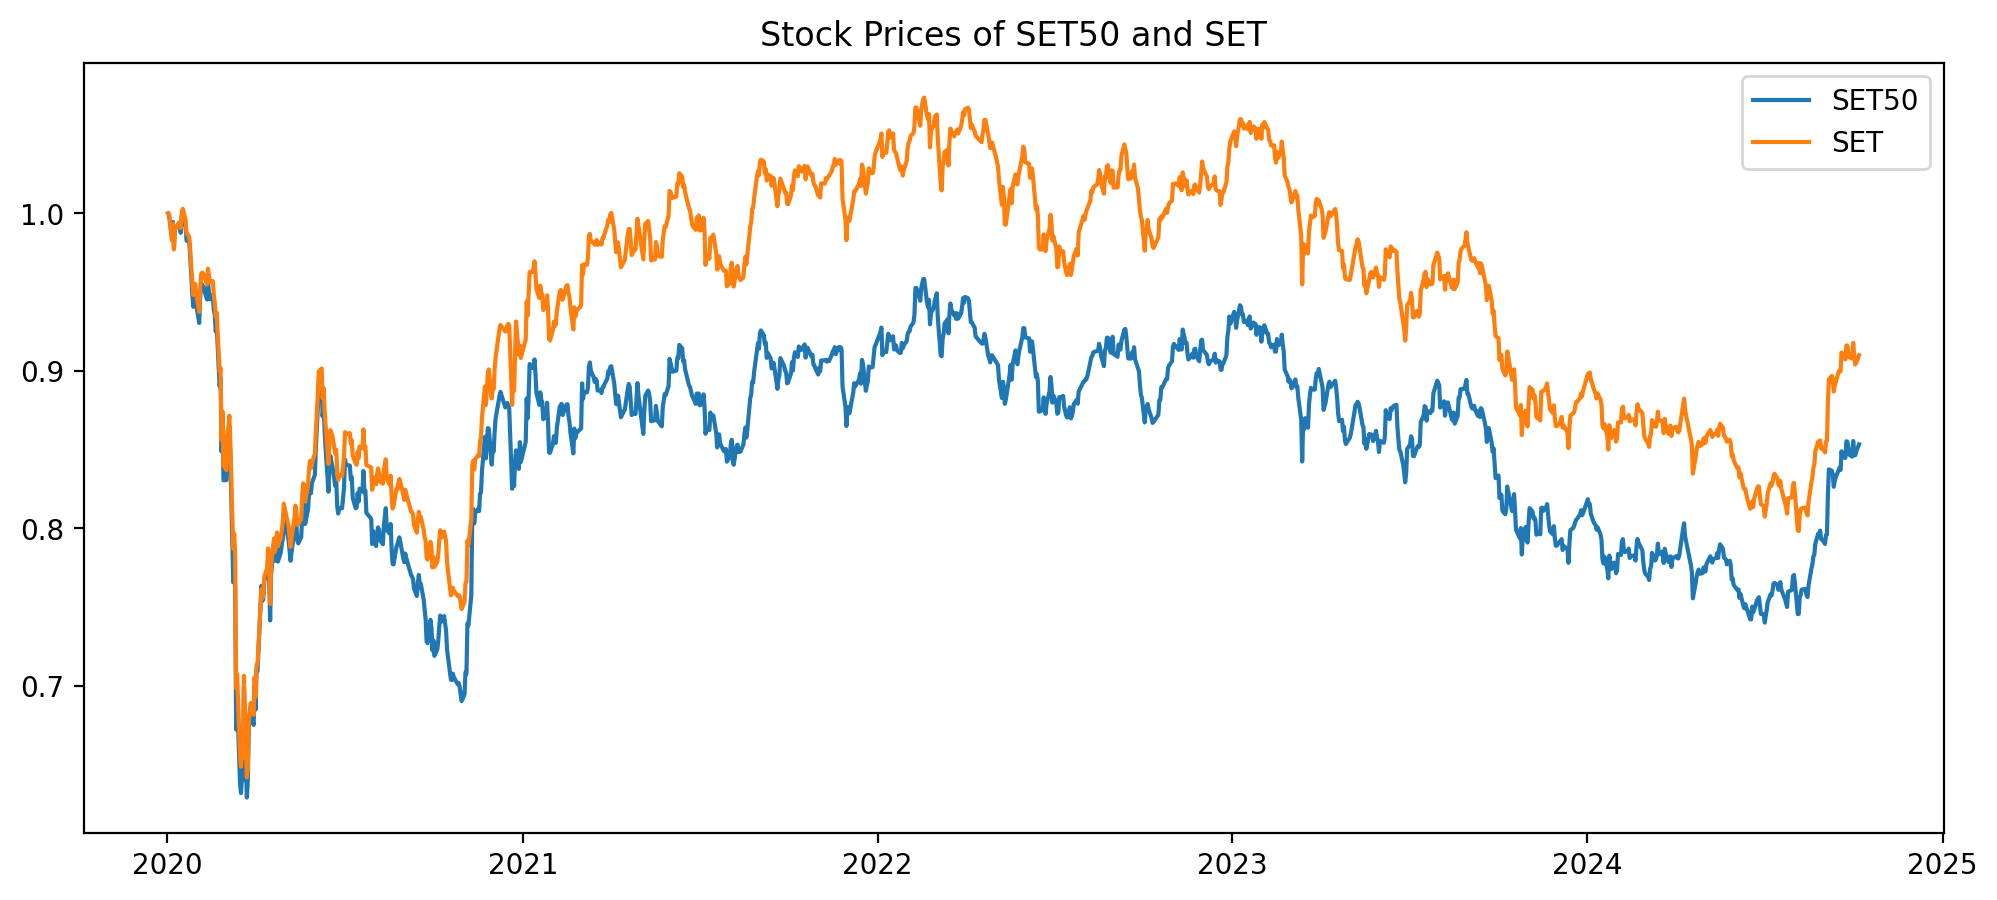

In [69]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# ดึงข้อมูลราคาหุ้น 2 ตัว
symbol1 = 'SET50'
symbol2 = 'SET'
df_symbol1 = dataReader.getPrice(symbol=symbol1,start='2020-01-01',stop='2024-10-07')
df_symbol2 = dataReader.getPrice(symbol=symbol2,start='2020-01-01',stop='2024-10-07')

df_symbol1['close_norm'] = df_symbol1['close']/df_symbol1['close'].iloc[0]
df_symbol2['close_norm'] = df_symbol2['close']/df_symbol2['close'].iloc[0]
# ทดสอบ Cointegration  
p1 = df_symbol1['close'] 
p2 = df_symbol2['close'] 

score, p_value, _ = coint(p1 ,p2)

if p_value < 0.05:
    print(f"มี Cointegration ระหว่างหุ้น {symbol1} และ {symbol2} , p_value = {p_value}")
else:
    print(f"ไม่มี Cointegration ระหว่างหุ้น {symbol1} และ {symbol2} , p_value = {p_value}")

# แสดงกราฟราคาหุ้น
plt.subplots(figsize=(12,5))
plt.plot(df_symbol1['close_norm'], label=symbol1)
plt.plot(df_symbol2['close_norm'], label=symbol2)
plt.title(f'Stock Prices of {symbol1} and {symbol2}')
plt.legend()
plt.show()

In [70]:
pd.concat([df_symbol1['close'],df_symbol2['close']],axis=1).corr()

close     close
close  1.000000  0.935024
close  0.935024  1.000000

การที่ในช่วงเวลาหนึ่งพบ Cointegration และในช่วงเวลาอื่นไม่พบ อาจมาจากกระบวนการปรับตัวของตลาดหลังจากเหตุการณ์สำคัญ ตัวอย่างเช่น หากมีเหตุการณ์ที่ทำให้ตลาดผิดเพี้ยนไปจากความสมดุลระยะยาว (เช่น วิกฤตการเงิน) ตลาดอาจต้องใช้เวลาในการปรับตัวกลับมาที่สมดุลเดิม ทำให้ในบางช่วงเวลาคุณไม่พบ Cointegration ในขณะที่ในช่วงอื่นอาจพบได้ <br>
- เราอาจมีความสัมพันธ์กับเพื่อนช่วงมัธยมและห่างกันไปเมื่อแยกย้ายเรียนมหาลัย และอาจกลับมาพบกันอีกช่วงทำงาน

## Correlation และ Cointegration
ความสัมพันธ์ระหว่าง Correlation และ Cointegration โดยจำลองข้อมูลเพื่อทดสอบกราฟจำนวน 4 แบบโดยมีความสัมพันธ์ดังนี้
1. มีค่า Correlation ที่สูงและค่า Cointegration ที่สูง
2. มีค่า Correlation ที่สูงและค่า Cointegration ที่ต่ำ
3. มีค่า Correlation ที่ต่ำและค่า Cointegration ที่สูง
4. มีค่า Correlation ที่ต่ำและค่า Cointegration ที่ต่ำ

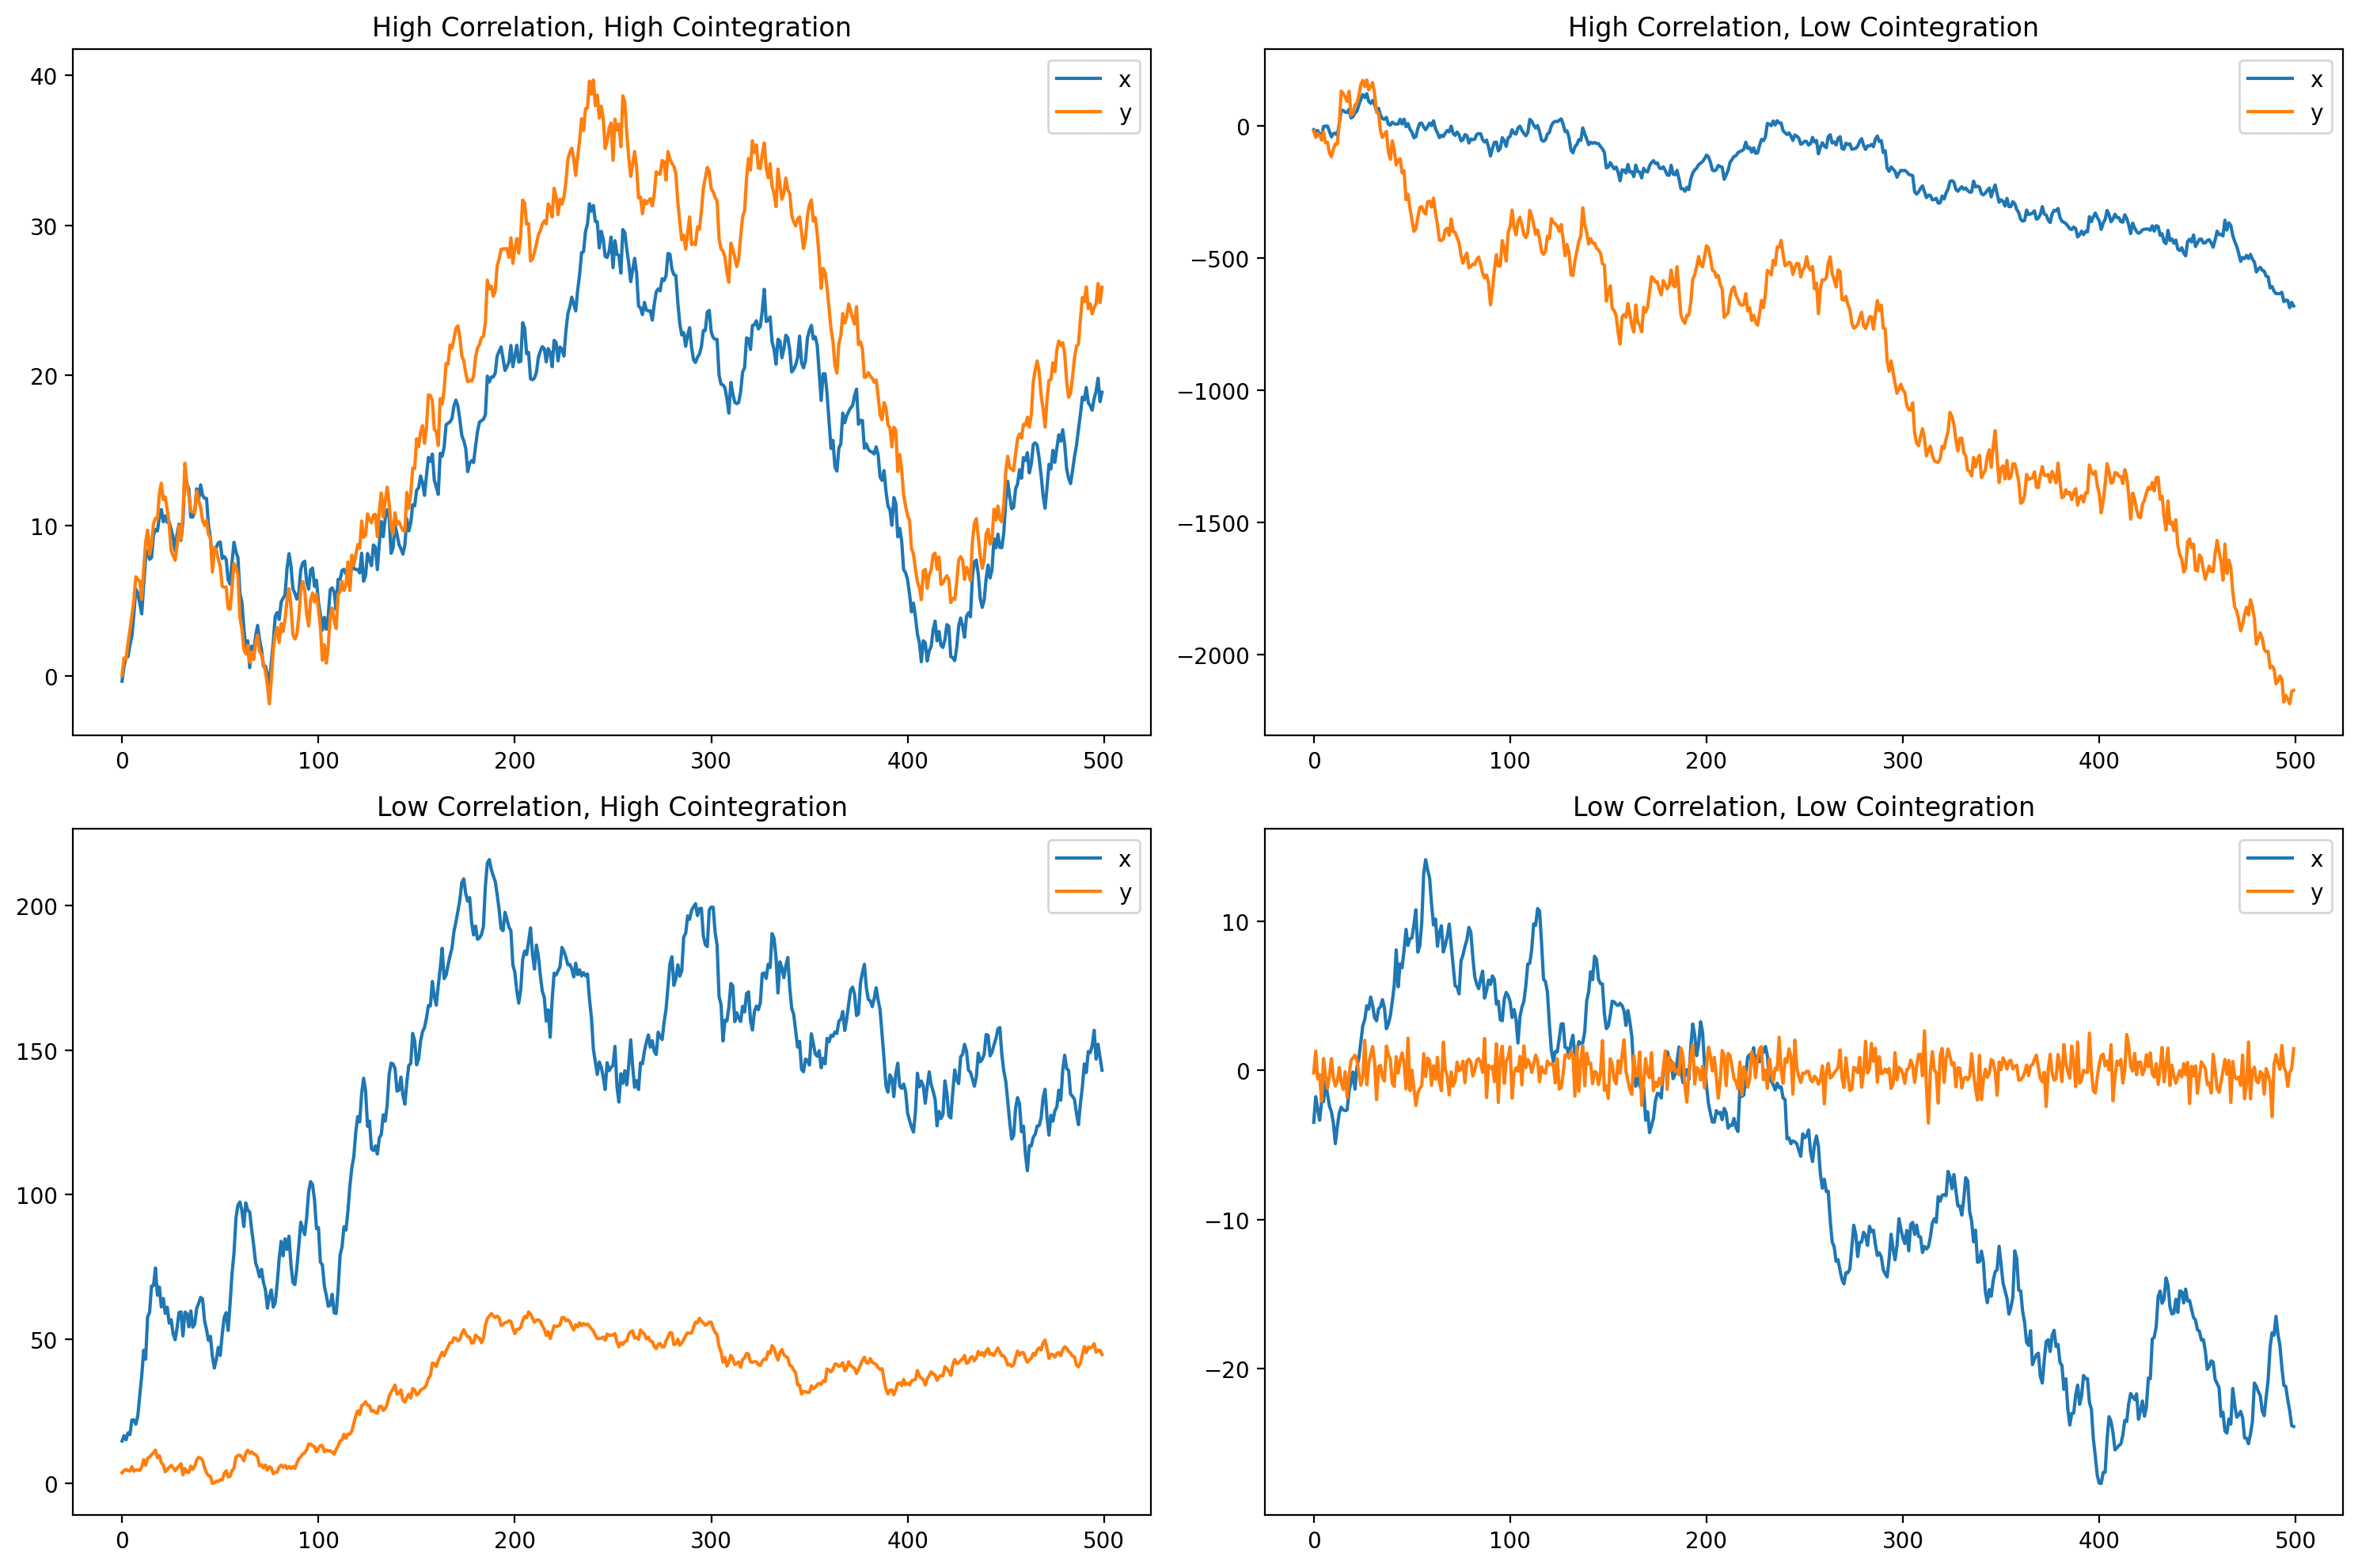

Cointegration Results


Correlation  Cointegration
Scenario                              
Scenario 1     0.993104       0.046924
Scenario 2     0.903118       0.389494
Scenario 3    -0.327025       0.095013
Scenario 4     0.001966       0.960719

In [200]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
%config InlineBackend.figure_format='retina'

# Generate synthetic data for four scenarios
np.random.seed(32)  # For reproducibility
n = 500  # Number of observations

# 1. High correlation, high cointegration
x1 = np.random.normal(0, 1, n).cumsum()
y1 = x1 + np.random.normal(0, 0.5, n).cumsum()
score, p_value1, _ = coint(x1 ,y1)


# 2. High correlation, low cointegration
x2 = np.random.normal(0, 20, n).cumsum()
y2 = 2*x2 + np.random.normal(0, 20, n).cumsum()  # High noise breaks cointegration
score, p_value2, _ = coint(x2 ,y2)

# 3. Low correlation, high cointegration
common_trend = np.random.normal(0, 1, n).cumsum()
x3 = common_trend*5 + np.random.normal(0, 1, n).cumsum()
y3 = common_trend + np.random.normal(0, 1, n).cumsum()
score, p_value3, _ = coint(x3 ,y3)

# 4. Low correlation, low cointegration
x4 = np.random.normal(0, 1, n).cumsum()
y4 = np.random.normal(0, 1, n)
score, p_value4, _ = coint(x4 ,y4)

# Create a DataFrame for analysis
data = pd.DataFrame({
    'x1': x1, 'y1': y1,
    'x2': x2, 'y2': y2,
    'x3': x3, 'y3': y3,
    'x4': x4, 'y4': y4
})

# Calculate correlation coefficients
correlation = data.corr()

# Plot the scenarios
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
scenarios = [(x1, y1, "High Correlation, High Cointegration"),
             (x2, y2, "High Correlation, Low Cointegration"),
             (x3, y3, "Low Correlation, High Cointegration"),
             (x4, y4, "Low Correlation, Low Cointegration")]

for ax, (x, y, title) in zip(axs.flatten(), scenarios):
    ax.plot(x, label='x')
    ax.plot(y, label='y')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()


c_1 = correlation_results[correlation_results[['x1']].index=='y1']['x1'].values[0]
c_2 = correlation_results[correlation_results[['x2']].index=='y2']['x2'].values[0]
c_3 = correlation_results[correlation_results[['x3']].index=='y3']['x3'].values[0]
c_4 = correlation_results[correlation_results[['x4']].index=='y4']['x4'].values[0]

corr = [c_1,c_2,c_3,c_4]
p_value = [p_value1,p_value2,p_value3,p_value4]
s = ['Scenario 1','Scenario 2','Scenario 3','Scenario 4']
report = pd.DataFrame({'Scenario':s,'Correlation':corr,'Cointegration':p_value,})
report = report.set_index('Scenario')
print(f'Cointegration Results') 
report

<b>สรุป</b><br>
ข้อมูลที่น่าเหมาะสมสำหรับกลยุทธ์ Pair Trading คือ Correlation สูงและ Cointegration สูง เนื่องจากสินทรัพย์มีทั้งความสัมพันธ์ในระยะสั้นและระยะยาว ซึ่งช่วยเสริมความคาดหวังของเราว่า ราคาทั้งสองจะกลับมาสู่สมดุลของราคาสินทรัพย์ได้